In [93]:
#general libraries
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

#scikit libraries
from sklearn import datasets
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt


#qiskit libraries
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit import execute
from qiskit import transpile, assemble
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
#qiskit circuit libraries
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap,PauliFeatureMap
from qiskit.circuit.library import RealAmplitudes

#qiskit optimizer libraries
from qiskit.algorithms.optimizers import SPSA,COBYLA

#qiskit algorithms
from qiskit_machine_learning.algorithms import VQC,QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier, PegasosQSVC
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit.utils import algorithm_globals

#qiskit azure libraries
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

In [94]:
# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

# Preprocess the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
N = X.shape[1]
print(N)

2


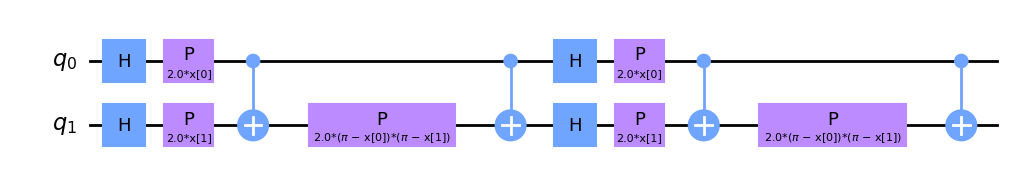

In [96]:
# Define the quantum feature map
feature_map = ZZFeatureMap(feature_dimension=N, reps=2, entanglement="linear")
feature_map.decompose().draw(output="mpl", fold=20)



In [97]:

qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('qasm_simulator'))

In [98]:
# SVM
svm = svm.SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [99]:
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average='macro')
svm_recall = recall_score(y_test, svm_pred, average='macro')
svm_f1 = f1_score(y_test, svm_pred, average='macro')

In [100]:
# Print the metrics for both models
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)

SVM Accuracy: 0.9666666666666667
SVM Precision: 0.9666666666666667
SVM Recall: 0.9696969696969697
SVM F1 Score: 0.9665831244778613


In [101]:
# Print the quantum kernel circuit
print(qkernel)

In [102]:
# Create the QSVC model
qsvm = QSVC(quantum_kernel=qkernel)
print(qsvm)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000029FE380A2F0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)


In [103]:
# Train the model
start = time.time()
epochs = 10
for _ in tqdm(range(epochs), desc="Training Progress"):
    qsvm.fit(X_train, y_train)
elapsed = time.time() - start



Training Progress: 100%|██████████| 10/10 [13:39<00:00, 81.90s/it]


In [104]:
# Predict labels for the test set
y_pred = qsvm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
qsvm_accuracy = np.sum(y_pred == y_test) / len(y_test)
qsvm_f1 = f1_score(y_test, y_pred, average='weighted')
qsvm_precision = precision_score(y_test, y_pred, average='weighted')
qsvm_recall = recall_score(y_test, y_pred, average='weighted')

In [105]:
# Calculate accuracy
print("Accuracy:", qsvm_accuracy)
print("F1-score:", qsvm_f1)
print("Precision:", qsvm_precision)
print("Recall:", qsvm_recall)

Accuracy: 0.8666666666666667
F1-score: 0.8578754578754579
Precision: 0.9022222222222223
Recall: 0.8666666666666667


In [106]:
print("Confusion Matrix:",cm)

Confusion Matrix: [[10  0  0]
 [ 0  5  4]
 [ 0  0 11]]


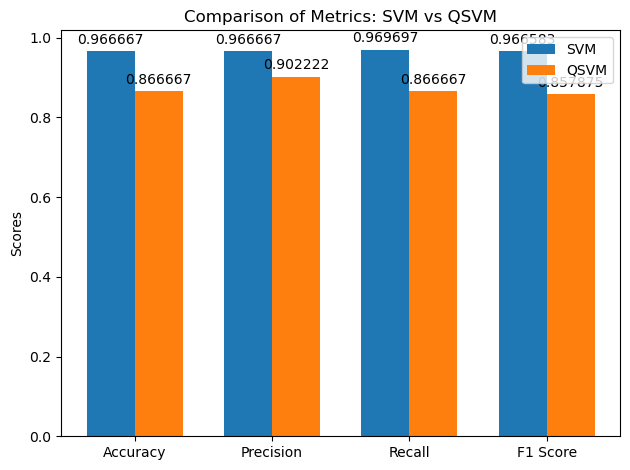

In [107]:
# Bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1]
qsvm_scores = [qsvm_accuracy, qsvm_precision, qsvm_recall, qsvm_f1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svm_scores, width, label='SVM')
rects2 = ax.bar(x + width/2, qsvm_scores, width, label='QSVM')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics: SVM vs QSVM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()